# Построение модели машинного обучения

In [1]:
import pandas as pd
import numpy as np

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Разделениe датасета
from sklearn.model_selection import train_test_split

# Поиск гиперпараметров
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV

# Метрики
from sklearn.metrics import (accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve)

# Векторизация текстовых данных TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Нормализация по длине документа
from sklearn.preprocessing import normalize

# Понижение размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import umap_

# Построение кривых
from sklearn.model_selection import learning_curve

# Визуализация
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### Пояснения по TfidfVectorizer и normalize
`Извлечение признаков из текстовых данных с использованием TF-IDF`

Term Frequency-Inverse Document Frequency (TF-IDF) — это один из наиболее распространенных и мощных методов для извлечения признаков из текстовых данных. TF-IDF вычисляет важность каждого слова в документе относительно количества его употреблений в данном документе и во всей коллекции текстов. Этот метод позволяет выделить ключевые слова и понять, какие слова имеют больший вес для определенного документа в контексте всей коллекции.

* https://habr.com/ru/companies/otus/articles/755772/
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

`Нормализация по длине документа normalize`

Когда мы вычисляем TF-IDF для слов в документах разной длины, длинные документы могут иметь более высокие значения TF, что может повлиять на точность результатов. Чтобы избежать этой проблемы, можно нормализовать значения TF-IDF по длине документа.


In [2]:
# Загрузка датафрейма
df_vv = pd.read_csv('data/df_marking.csv')

## Подготовка данных для обучения

In [3]:
df_vv.columns

Index(['author', 'comment', 'comment_pre_processing', 'date', 'url', 'product',
       'stars', 'price', 'currency', 'weight',
       'target_by_RuBRT-tiny_no_processing', 'target_by_stars',
       'target_by_RuBRT-tiny_processing'],
      dtype='object')

In [4]:
# проверим данные на пропуски
df_vv.isnull().sum()

author                                0
comment                               0
comment_pre_processing                8
date                                  0
url                                   0
product                               0
stars                                 0
price                                 0
currency                              0
weight                                0
target_by_RuBRT-tiny_no_processing    0
target_by_stars                       0
target_by_RuBRT-tiny_processing       0
dtype: int64

In [5]:
df_vv[df_vv['comment_pre_processing'].isnull()]

,author,comment,comment_pre_processing,date,url,product,stars,price,currency,weight,target_by_RuBRT-tiny_no_processing,target_by_stars,target_by_RuBRT-tiny_processing
113,Юлия,👍,NaN,11 мая 2025 · Карта: xxx68,https://vkusvill.ru/goods/chesnok-fermerskiy-1...,"Чеснок Фермерский,100 г",5,143,руб,/шт,0,1,0
2071,ОЛЬГА ИВАНОВНА,Так себе,NaN,11 мая 2025 · Карта: xxx45,https://vkusvill.ru/goods/ogurtsy-gladkie-1664...,Огурцы гладкие,4,150,руб,/кг,0,1,0
2340,Виктрия,😋,NaN,04 апр 2025 · Карта: xxx96,https://vkusvill.ru/goods/grusha-vilyams-22334...,Груша Вильямс,5,342,руб,/кг,0,1,0
2481,Анна,вку,NaN,03 мая 2025 · Карта: xxx74,https://vkusvill.ru/goods/kapusta-belokochanna...,Капуста белокочанная,5,90,руб,/кг,0,1,0
2632,Людмила,👍,NaN,17 мая 2025 · Карта: xxx18,https://vkusvill.ru/goods/perets-krasnyy-sladk...,Перец красный сладкий,5,370,руб,/кг,0,1,0
2636,Сундус,😍,NaN,16 мая 2025 · Карта: xxx08,https://vkusvill.ru/goods/perets-krasnyy-sladk...,Перец красный сладкий,5,370,руб,/кг,0,1,0
2692,Ирина,По ЗЦ,NaN,12 мая 2025 · Карта: xxx13,https://vkusvill.ru/goods/perets-krasnyy-sladk...,Перец красный сладкий,5,370,руб,/кг,0,1,0
4222,Ирина,Щ,NaN,14 мая 2025 · Карта: xxx51,https://vkusvill.ru/goods/banany-731.html,Бананы,5,178,руб,/кг,0,1,0


In [6]:
# удалим образовавшиеся пропуски в процессе лемматизации
df_vv = df_vv.dropna(subset=['comment_pre_processing'])

In [7]:
df = df_vv.copy()

## Выбор целевой переменной

`Построим графики распределений целевых переменных`

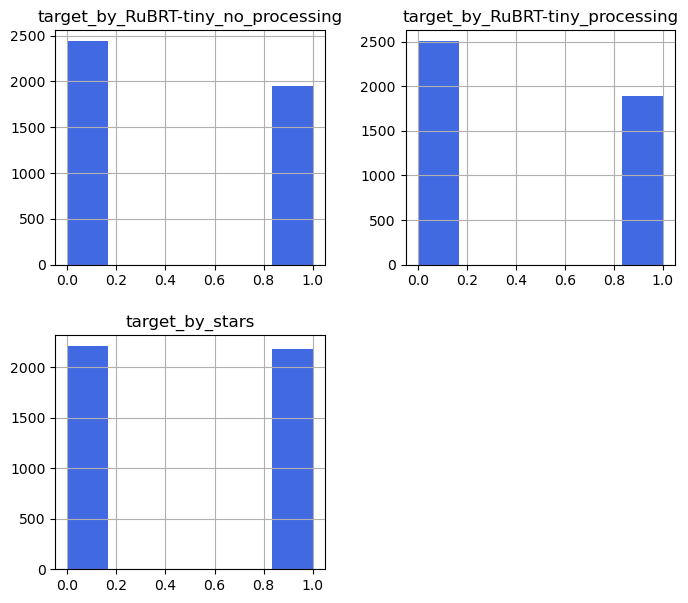

In [8]:
graphics_df = df[['target_by_RuBRT-tiny_no_processing', 'target_by_RuBRT-tiny_processing', 'target_by_stars']]
graphics_df.hist(figsize=(8, 7), bins=6, grid=True, color='royalblue');

#### Сейчас мы не можем точно сказать, какая из целевых переменных наиболее точно отражает настроение отзывов. Поэтому сделаем несколько срезов и случайным образом выберем 5 выборок по 100 отзывов и  разметим их в ручную с помощь интрумента разметки Label Studio 

In [9]:
# Перемешаем отзывы
df_shufle = df[['comment', 'target_by_RuBRT-tiny_no_processing', 'target_by_RuBRT-tiny_processing', 'target_by_stars']].sample(frac=1)

In [10]:
df_shufle[:3]

,comment,target_by_RuBRT-tiny_no_processing,target_by_RuBRT-tiny_processing,target_by_stars
3873,"нормальные, немного не хватает хрустости и соч...",1,1,1
3057,"Очень сладкая, удачная дыня.",1,1,1
1890,"Вкусные , свежие",1,1,1


In [11]:
# Выберем 5 случаных выборок по 100 отзывов для ручной разметки
sample_1 = df_shufle[:1000].sample(100)
sample_2 = df_shufle[1001:1800].sample(100)
sample_3 = df_shufle[1801:2500].sample(100)
sample_4 = df_shufle[2501:3500].sample(100)
sample_5 = df_shufle[3501:4300].sample(100)

df_sample = df_vv = pd.concat([sample_1, sample_2, sample_3, sample_4, sample_5], axis=0)
#df_sample.to_csv('df_sample_for marking2.csv', encoding='utf-8', index=False)

`Разметим отзывы инструментом Label Studio`

In [12]:
# Загрузим размеченные в ручную отзывы
df_ls_marking = pd.read_csv('data/df_samle_label_studio_marking.csv')
graf_ls_marking = df_ls_marking[['sentiment', 'target_by_RuBRT-tiny_no_processing', 'target_by_RuBRT-tiny_processing', 'target_by_stars']]

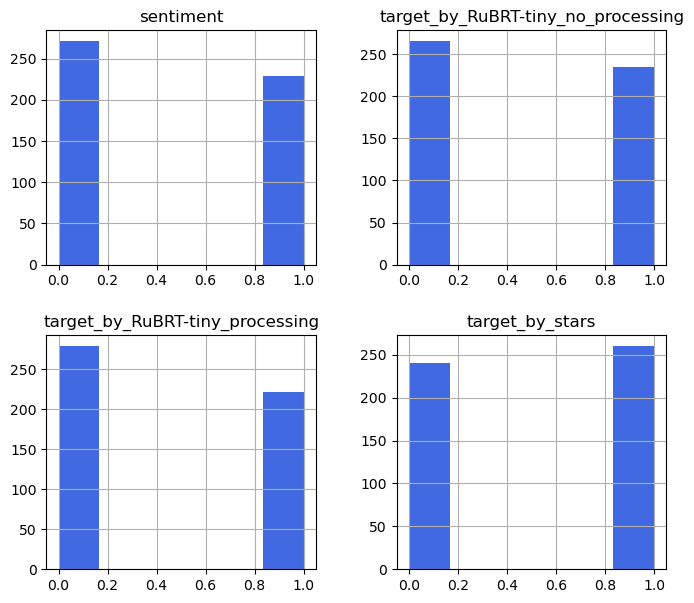

In [13]:
# Построим графики их распределений с учетом размеченных в ручную 'sentiment'
graf_ls_marking.hist(figsize=(8, 7), bins=6, grid=True, color='royalblue');

In [14]:
# Сравниваем 'sentiment' c 'target_by_RuBRT-tiny_no_processing', 'target_by_RuBRT-tiny_processing', 'target_by_stars' и записываем результат сравнения в compare
compare = graf_ls_marking.copy()
compare['sentiment_vs_RuBRT-tiny_no_processing'] = compare['sentiment'] == compare['target_by_RuBRT-tiny_no_processing']
compare['sentiment_vs_RuBRT-tiny_processing'] = compare['sentiment'] == compare['target_by_RuBRT-tiny_processing']
compare['sentiment_vs_target_by_stars'] = compare['sentiment'] == compare['target_by_stars']

In [15]:
for col in compare.columns[4:]:
    print(col, compare[col].sum())

sentiment_vs_RuBRT-tiny_no_processing 442
sentiment_vs_RuBRT-tiny_processing 430
sentiment_vs_target_by_stars 461


#### Выводы по выбору целевой переменной:

Теперь мы можем с уверенностью сказать, что признак `target_by_stars` наиболее точно описывыет настроение отзывов 461 совпадений из 500.
* Берем `target_by_stars`, как целевую переменную для обучения

Также следует отметить, что нейрость RuBRT-tiny показала хороший результат в оценке семантики отзывов 442 из 500

## Подготовим признак `comment_pre_processing` для обучения

#### Протестируем работу TfidfVectorizer на маленькой выборке

In [16]:
# Проверим работу векторайзера на маленькой выборке
tets_data = df['comment_pre_processing'][:5]
tets_data

0                                     очень вкусный ❤️
1    вкусный персик спелый сочный свежий сладкий ки...
2    бесвкусный переспелый заказать специально немн...
3    курьер привезти всё мятый следующий не дожить ...
4    привезти спелый вполне подходить сила дождатьс...
Name: comment_pre_processing, dtype: object

In [17]:
# Применение TF-IDF к текстовым данным
test_tfidf_vectorizer = TfidfVectorizer()
test_tfidf_matrix = test_tfidf_vectorizer.fit_transform(tets_data)

# Получение списка ключевых слов и их значения TF-IDF для первого отзыва
feature_names = test_tfidf_vectorizer.get_feature_names_out()
tfidf_scores = test_tfidf_matrix.toarray()[0]

# Сортировка слов по значениям TF-IDF
sorted_keywords = [word for _, word in sorted(zip(tfidf_scores, feature_names), reverse=True)]

print("Ключевые слова:", sorted_keywords)
len(sorted_keywords)

Ключевые слова: ['очень', 'вкусный', 'хотя', 'увеличить', 'убрать', 'ставить', 'специально', 'спелый', 'сочный', 'следующий', 'сладость', 'сладкий', 'сила', 'сезон', 'свежий', 'самостоятельно', 'привезти', 'понравиться', 'половина', 'подходить', 'персик', 'переспелый', 'немного', 'не', 'мятый', 'мягкий', 'маленький', 'курьер', 'кислинка', 'испортиться', 'звезда', 'заказывать', 'заказать', 'доставка', 'дожить', 'дождаться', 'всё', 'вполне', 'видно', 'вес', 'бесвкусный']


41

`Определение порога для отбора ключевых слов`

In [18]:
# Применение TF-IDF к текстовым данным
test_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2)) # Используем N-gras и TF-IDF для более точного извлечения признаков из текста
test_tfidf_matrix = test_tfidf_vectorizer.fit_transform(tets_data)

# Определение порога для отбора ключевых слов
threshold = 0.2
important_words = [word for word, score in zip(test_tfidf_vectorizer.get_feature_names_out(), 
                                               test_tfidf_matrix.toarray()[0]) if score >= threshold]
print("Важные слова:", important_words)
print("Ключевые слова:", sorted_keywords)
len(sorted_keywords)

Важные слова: ['вкусный', 'очень', 'очень вкусный']
Ключевые слова: ['очень', 'вкусный', 'хотя', 'увеличить', 'убрать', 'ставить', 'специально', 'спелый', 'сочный', 'следующий', 'сладость', 'сладкий', 'сила', 'сезон', 'свежий', 'самостоятельно', 'привезти', 'понравиться', 'половина', 'подходить', 'персик', 'переспелый', 'немного', 'не', 'мятый', 'мягкий', 'маленький', 'курьер', 'кислинка', 'испортиться', 'звезда', 'заказывать', 'заказать', 'доставка', 'дожить', 'дождаться', 'всё', 'вполне', 'видно', 'вес', 'бесвкусный']


41

#### Применим TfidfVectorizer ко всей вырбоке

In [19]:
# Применение TF-IDF к признаку 'comment_pre_processing'
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True, max_features=None) # Используем N-gras и TF-IDF для более точного извлечения признаков из текста
df_tfidf_matrix = tfidf_vectorizer.fit_transform(df['comment_pre_processing'])
df_tfidf_matrix.shape

(4387, 21234)

In [20]:
# Нормализация матрицы TF-IDF по длине документа
# Когда мы вычисляем TF-IDF для слов в документах разной длины, длинные документы могут иметь более высокие значения TF, что может повлиять на точность результатов. 
# Чтобы избежать этой проблемы, нормализуем значения TF-IDF по длине документа. 
df_tfidf_matrix_normalized = normalize(df_tfidf_matrix, norm='l2', axis=1)
df_tfidf_matrix_normalized.shape

(4387, 21234)

In [21]:
from scipy.sparse import csr_matrix

# Преобразование в разреженную матрицу
sparse_matrix = csr_matrix(df_tfidf_matrix_normalized)
sparse_matrix.shape

(4387, 21234)

`На выходе мы получили дастаточно большую матрицу с более 20_000 признаками`

### Применим к полученным векторам TF-IDF линейные методы понижения размерности PCA и нелинейные t-SNE, UMAP

Уменьшение размерности данных — это подход упрощения сложных наборов данных для облегчения их обработки. По мере того как данные растут и становятся более сложными, извлекать информацию становится все труднее, а визуализация становится более накладной. Методы уменьшения размерности данных решают эту проблему, предоставляя меньшее количество измерений (столбцов) при сохранении наиболее важной информации. Мы можем потерять некоторые детали, но получить более простое представление данных, которое легче обрабатывать и сравнивать.

* https://habr.com/ru/articles/751050/

### PCA (Principal Component Analysis)

* Анализ главных компонент (PCA) уменьшает размерность набора данных, максимизируя при этом дисперсию интерпретации каждого основного компонента.

In [22]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(df_tfidf_matrix.toarray())

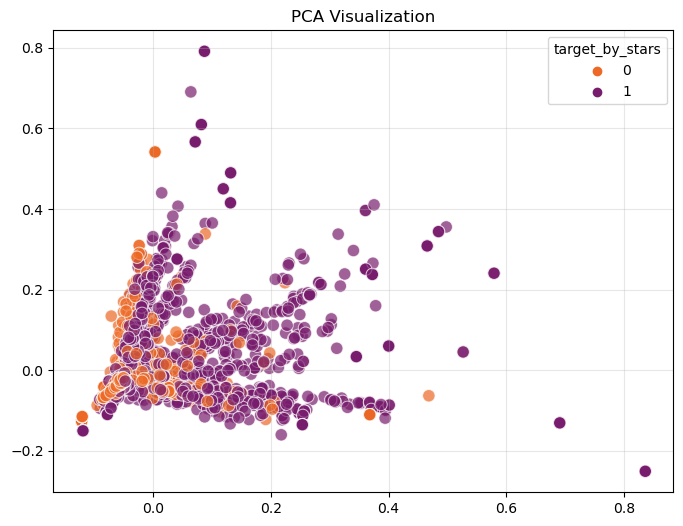

In [23]:
# Визуализируем полученый результат
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df['target_by_stars'], alpha=0.7, linewidths=2, s=80, palette='inferno_r')
plt.grid(alpha=0.3)
plt.title("PCA Visualization")
plt.show()

### t-SNE (t-Distributed Stochastic Neighbor Embedding)

t-SNE (стохастическое вложение соседей с t-распределением) — это алгоритм, используемый для упрощения и визуализации сложных данных. Он достигает этой цели путем сравнения сходства между точками данных в исходном пространстве высокой размерности и пространстве низкой размерности. Затем он создает распределение вероятностей для представления этих сходств, стремясь сделать их как можно более похожими. Алгоритм итеративно корректирует положение точек данных в низкоразмерном пространстве до тех пор, пока распределение не станет максимально близким.

In [24]:
%%time
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1, perplexity=20)
tsne_result = tsne.fit_transform(df_tfidf_matrix.toarray())

# Подбор параметров:
# perplexity=20 лучший результат
# perplexity=10

CPU times: user 2min 24s, sys: 4.56 s, total: 2min 28s
Wall time: 19.7 s


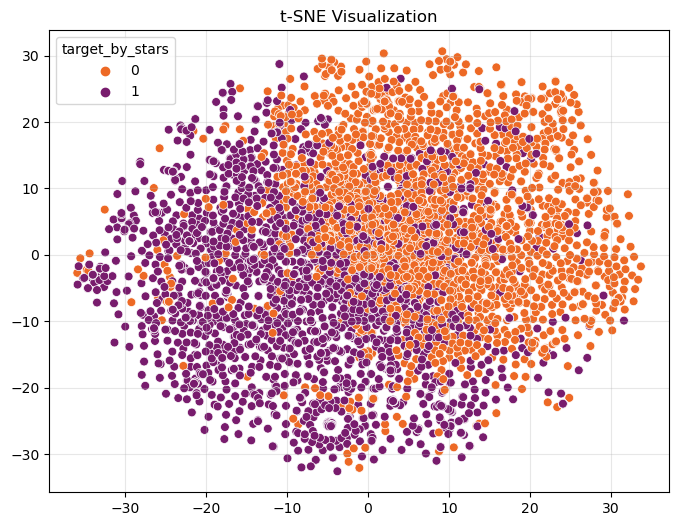

In [25]:
# Визуализируем полученый результат
plt.figure(figsize=(8,6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=df['target_by_stars'], legend='full', alpha=1, linewidths=3, s=40, palette='inferno_r')
plt.title('t-SNE Visualization')
plt.grid(alpha=0.3)
plt.show()

### UMAP (Uniform Manifold Approximation and Projection) `ПОКА ОТКЛЮЧИМ ДОЛГОЕ ВЫПОЛНЕНИЕ`

Uniform Manifold Approximation and Projection (сокращенно UMAP) UMAP можно рассматривать как более мощного родственника t-SNE.Он также изучает нелинейные отображения для поддержания целостности кластера, и это происходит быстрее. Кроме того, по сравнению с t-SNE, UMAP, как правило, лучше справляется с поддержанием глобальной структуры данных. В этом контексте глобальная структура относится к «степени близости» между похожими типами вин, в то время как локальная структура относится к степени кластеризации одного и того же типа вина в уменьшенном по размерам пространстве.



- Метрики для бинарных данных: `hamming`, `jaccard`, `dice`, `russellrao`, `kulsinski`, `rogerstanimoto`, `sokalmichener`, `sokalsneath`, `yule`


* https://umap-learn.readthedocs.io/en/latest/parameters.html

In [26]:
%%time
umap = umap_.UMAP(n_components=2, random_state=42,n_neighbors=12, min_dist=1, metric='sokalsneath')
umap_result = umap.fit_transform(df_tfidf_matrix.toarray())

# Подбор параметров:
# n_neighbors=22, min_dist=1, metric='kulsinski'
# n_neighbors=12, min_dist=1, metric='sokalsneath' лучший результат
# n_neighbors=13, min_dist=1, metric='russellrao'
# n_neighbors=20, min_dist=1, metric='russellrao'

CPU times: user 1min 52s, sys: 1.44 s, total: 1min 53s
Wall time: 1min 51s


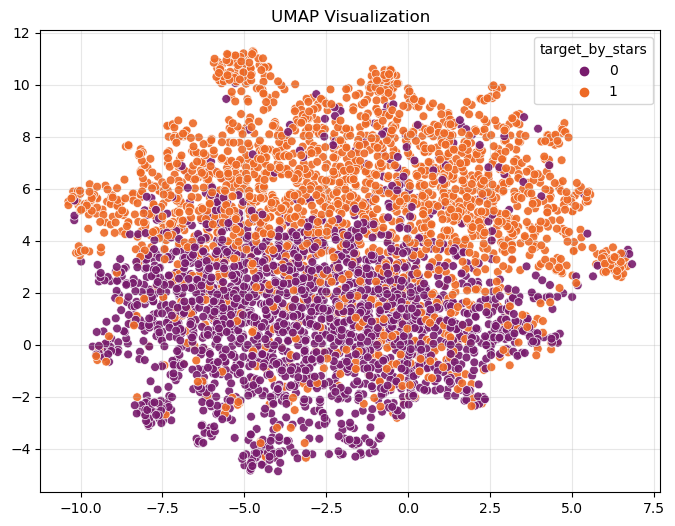

In [46]:
# Визуализируем полученый результат
plt.figure(figsize=(8,6))
sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=df['target_by_stars'], legend='full', alpha=0.9, s=40, palette='inferno')
plt.title('UMAP Visualization')
plt.grid(alpha=0.3)
plt.show()

### `Выводы`
* Нелинейные алгоритмы понижения размерности t-SNE (t-Distributed Stochastic Neighbor Embedding) и UMAP (Uniform Manifold Approximation and Projection) наиболее точно разделили наши данные

## Обучение моделей

In [28]:
# Посмотрим на баланс классов
df['target_by_stars'].value_counts()

0    2207
1    2180
Name: target_by_stars, dtype: int64

`Целевая переменная сбалансированная`

#### Выбор метрики accuracy

* Выбор метрики точности accuracy зависит от задачи и специфики данных. В целом, это хорошая метрика для оценки общей точности модели, но при несбалансированных классах или когда некоторые ошибки более критичны, чем другие, могут потребоваться другие метрики.

Accuracy подходит для сбалансированных классов:
Когда количество примеров каждого класса примерно одинаково, accuracy является хорошим показателем общей производительности модели

#### Разделим датасет на данные для обучения и тестирования

In [29]:
X = df_tfidf_matrix
y = df['target_by_stars'] # цедевая переменная

test_size = 0.35 # размер тестовой выборки

# без понижения размерности
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
# c понижением размерности (PCA, t-SNE, UMAP)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_result, y, test_size=test_size, random_state=42) # PCA
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(tsne_result, y, test_size=test_size, random_state=42) # t-SNE
X_train_umap, X_test_umap, y_train_umap, y_test_umap = train_test_split(umap_result, y, test_size=test_size, random_state=42) # UMAP

In [47]:
X_train.shape, X_train_pca.shape, X_train_tsne.shape, X_train_umap.shape

((2851, 21234), (2851, 2), (2851, 2), (2851, 2))

In [31]:
# Функция для обучения модели и оценки метрик
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
   
    return accuracy, f1

#### Обучим несколько моделей: 
* LogisticRegression, 
* RandomForestClassifier, 
* GradientBoostingClassifier, 
* XGBClassifier

In [32]:
%%time
# Определим модели и обучим со стандартными параметрами
model_lr = LogisticRegression(random_state=42) 
model_rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
model_gbc = GradientBoostingClassifier(random_state=42)
model_xgb = XGBClassifier(random_state=42, n_jobs=-1)

models = [model_lr, model_rfc, model_gbc, model_xgb]
result_model = []

for model in models: 
    accuracy, f1 = evaluate_model(model, X_train, X_test, y_train, y_test)
    accuracy_pca, f1_pca = evaluate_model(model, X_train_pca, X_test_pca, y_train_pca, y_test_pca)
    accuracy_tsne, f1_tsne = evaluate_model(model, X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne)
    accuracy_umap, f1_umap = evaluate_model(model, X_train_umap, X_test_umap, y_train_umap, y_test_umap)
    model_name = str(model).split('(')[0]
    
    model_dict = {
        'model' : model_name,
        'Accuracy': round(accuracy, 4), # Без понижения размерности
        'F1': round(f1, 4), # Без понижения размерности
        'PCA_Accuracy': round(accuracy_pca, 4),
        'PCA_F1': round(f1_pca, 4),
        't-SNE_Accuracy': round(accuracy_tsne, 4),
        't-SNE_F1': round(f1_tsne, 4),
        'UMAP_Accuracy': round(accuracy_umap, 4),
        'UMAP_F1': round(f1_umap, 4),
         }
    
    result_model.append(model_dict)    

CPU times: user 50.4 s, sys: 1.8 s, total: 52.2 s
Wall time: 14.4 s


`Посмотрим на результаты обучения моделей`

In [33]:
pd.DataFrame(result_model)

,model,Accuracy,F1,PCA_Accuracy,PCA_F1,t-SNE_Accuracy,t-SNE_F1,UMAP_Accuracy,UMAP_F1
0,LogisticRegression,0.8724,0.8718,0.6947,0.6849,0.8405,0.8404,0.8158,0.8157
1,RandomForestClassifier,0.8535,0.8535,0.7383,0.7381,0.8503,0.8503,0.8014,0.8011
2,GradientBoostingClassifier,0.8418,0.8406,0.7428,0.7424,0.8574,0.8572,0.8301,0.8296
3,XGBClassifier,0.8633,0.8629,0.7292,0.7288,0.8503,0.8502,0.8021,0.8017


### Выводы: 
* Как и ожидалось алгоритм понижения размерности t-SNE с моделями RandomForestClassifier, GradientBoostingClassifier, XGBClassifier показал наилучшие результаты
* Подберем гиперпараметры для достижения наилучших метрик с помощью GridSearchCV, а также выполним кроссвалидацию

### `Подбор гиперпараметров:`

Процесс обучения модели поэтапный: начинается он с обработки данных, имеет стадию тюнинга, отдельную стадию обкатки и проверки. Рассмотрим подробнее процесс тюнинга модели при помощи GridSearchCV (библиотеки sklearn), которая выберет наилучшие параметры модели

 * https://habr.com/ru/companies/otus/articles/698370/
 * https://newtechaudit.ru/gridsearchcv-pomoshhnik-v-vybore/

`RandomForestClassifier` `GradientBoostingClassifier` `XGBClassifier`

In [34]:
%%time
# Подбор гиперпараметров для улучшения результатов
params = {'n_estimators': [5 ,10, 20, 30, 50, 100], #  100, 150
          'max_depth': [2, 4, 5, 8, 10, 15, 20, 30],
          #'min_samples_leaf': [1, 2, 3, 4, 5, 8]
         }

result_grid_search = [] # список для результатов

models = [model_rfc, model_gbc, model_xgb] # список моделей

for model in models:
    gs_model = GridSearchCV(model, 
                      params,
                      scoring='accuracy',
                      cv=KFold(n_splits=5, # колич. разбиений/итераций в кросс-валидации
                               random_state=42,
                               shuffle=True),
                      n_jobs=-1
                     )

    gs_model.fit(X_test_tsne, y_test_tsne)

    name_model = str(gs_model.estimator).split('(')[0]

    best_params = {
        'model' : name_model,
        'best_n_estimators': gs_model.best_params_['n_estimators'],
        'best_max_depth': gs_model.best_params_['max_depth'],
        #'best_min_samples_leaf': gs_model.best_params_['min_samples_leaf'],
        'best_score': gs_model.best_score_
        }

    result_grid_search.append(best_params)

CPU times: user 3.97 s, sys: 858 ms, total: 4.83 s
Wall time: 24.6 s


`Посмотрим на результаты наилучшых гиперпараметров`

In [35]:
pd.DataFrame(result_grid_search)

,model,best_n_estimators,best_max_depth,best_score
0,RandomForestClassifier,50,5,0.848949
1,GradientBoostingClassifier,20,4,0.848957
2,XGBClassifier,30,2,0.846996


`Обучим мадель с наилучшими параметрами`

In [36]:
best_model = GradientBoostingClassifier(random_state=42, n_estimators=20, max_depth=4, min_samples_leaf=1) #n_jobs =-1max_features=1.0 min_samples_leaf=1 , n_estimators=30, max_depth=5
best_model.fit(X_train_tsne, y_train_tsne)


predictions = best_model.predict(X_test_tsne)

print(classification_report(y_test_tsne, predictions))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       758
           1       0.89      0.81      0.85       778

    accuracy                           0.85      1536
   macro avg       0.86      0.86      0.85      1536
weighted avg       0.86      0.85      0.85      1536



`Построим матрицу ошибок`

In [44]:
# Сохрание модели.....
from joblib import dump, load
dump(best_model, "models/best_model.pkl")

['models/best_model.pkl']

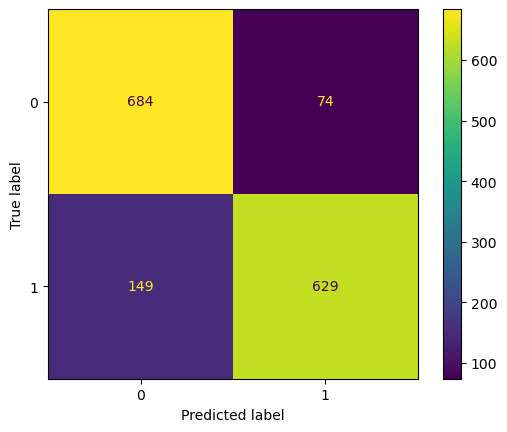

In [38]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_tsne, predictions))
disp.plot()
plt.show()

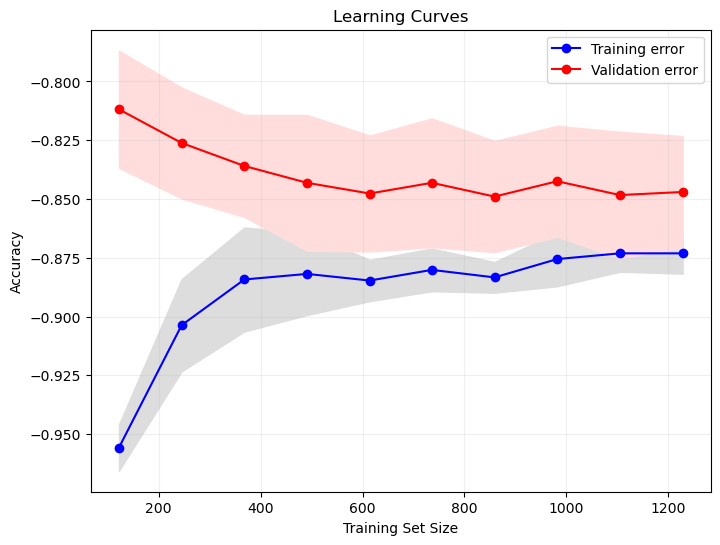

In [39]:
# Получение кривых обучения
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=best_model, n_jobs= -1,
    X=X_test_tsne,
    y=y_test_tsne,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy'
)

# Средние значения и стандартное отклонение ошибок обучения
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Средние значения и стандартное отклонение ошибок валидации
validation_mean = -np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Построение графиков
plt.figure(figsize=(8,6))
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='#DDDDDD')
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='#FFDDDD')
plt.plot(train_sizes, train_mean, 'o-', color='b', label='Training error')
plt.plot(train_sizes, validation_mean, 'o-', color='r', label='Validation error')

plt.title('Learning Curves')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [40]:
model_catboost = CatBoostClassifier(
                                    iterations=20,
                                    random_seed=80,
                                    learning_rate=1,
                                    early_stopping_rounds=20
                                    )

model_catboost.fit(
                    X_train_tsne, y_train_tsne,
                    eval_set=(X_test_tsne, y_test_tsne),
                    verbose=False,
                    plot=True
                )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [41]:
predictions_cat = model_catboost.predict(X_test_tsne)
print(classification_report(y_test_tsne, predictions_cat))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       758
           1       0.88      0.83      0.86       778

    accuracy                           0.86      1536
   macro avg       0.86      0.86      0.86      1536
weighted avg       0.86      0.86      0.86      1536



In [45]:
# Сохрание модели.....
from joblib import dump, load
dump(model_catboost, "models/cat_model.pkl")

['models/cat_model.pkl']

In [43]:
# Выводы.....